In [1]:
from skscope import GraspSolver
import jax.numpy as jnp
import numpy as np
from sklearn.datasets import make_sparse_spd_matrix
import cvxpy as cp
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
n, p = 150, 30
prng = np.random.RandomState(1)
prec_common = make_sparse_spd_matrix(p, alpha=0.98, smallest_coef=0.6, largest_coef=1.0, random_state=prng)
prec1 = make_sparse_spd_matrix(p, alpha=0.995, smallest_coef=0.7, largest_coef=0.9, random_state=prng)
prec2 = make_sparse_spd_matrix(p, alpha=0.995, smallest_coef=0.7, largest_coef=0.9, random_state=prng)
prec3 = make_sparse_spd_matrix(p, alpha=0.995, smallest_coef=0.7, largest_coef=0.9, random_state=prng)
prec_list = [prec1, prec2, prec3]
prec_sample_list = []
for prec in prec_list:
    prec = prec + prec_common
    cov = np.linalg.inv(prec)
    d = np.sqrt(np.diag(cov))
    cov /= d
    cov /= d[:, np.newaxis]
    prec *= d
    prec *= d[:, np.newaxis]
    X = prng.multivariate_normal(np.zeros(p), cov, size=n)
    X -= X.mean(axis=0)
    X /= X.std(axis=0)

    # sample covariance and precision matrix
    cov_sample = np.cov(X.T)
    prec_sample = np.linalg.inv(cov_sample)
    prec_sample_list.append(prec_sample)

In [3]:
def joint_sparse_precision_loss(params, sample_covariance_matrix_list):
    p = sample_covariance_matrix_list[0].shape[0]
    Omega_list = []
    Omega = jnp.zeros((p, p))
    Omega = Omega.at[np.triu_indices(p)].set(params)
    Omega = jnp.where(Omega, Omega, Omega.T)
    return jnp.trace(jnp.matmul(sample_covariance_matrix, Omega)) - jnp.linalg.slogdet(Omega)[1]

class Graphical_Guassian_Solver(GraspSolver):
    def _cache_nlopt(
        self,
        loss_fn,
        value_and_grad,
        init_params,
        optim_variable_idx,
        data,
        background_params=None,
    ):
        """
        use cvxpy to solve the problem: min_{x} f(params) s.t. vec_to_mat(params) is PSD
        where params = (x, y), the index of x is `optim_variable_idx`, y $\equiv$ `background_params[~optim_variable_idx]`
        here, `background_params` is all-zeros
        """
        p = data.shape[0]
        dim = int(p * (p + 1) / 2)
        s = len(optim_variable_idx)

        opt_mark_vec = np.zeros(dim, dtype=bool)
        opt_mark_vec[optim_variable_idx] = True
        opt_indices_mat = (
            np.triu_indices(p)[0][opt_mark_vec],
            np.triu_indices(p)[1][opt_mark_vec],
        )
        non_opt_indices_mat = (
            np.triu_indices(p)[0][~opt_mark_vec],
            np.triu_indices(p)[1][~opt_mark_vec],
        )

        Omega = cp.Variable((p, p), PSD=True)

        constraints = [
            Omega[non_opt_indices_mat] == np.zeros(dim - s),
        ]

        # graphical_guassian_loss = cp.sum(cp.multiply(data, Omega)) - cp.log_det(Omega)
        graphical_guassian_loss = cp.trace(data @ Omega) - cp.log_det(Omega)

        prob = cp.Problem(cp.Minimize(graphical_guassian_loss), constraints)
        prob.solve()

        return Omega.value[opt_indices_mat], graphical_guassian_loss.value

In [4]:
solver = Graphical_Guassian_Solver(
    dimensionality=int(p * (p + 1) / 2),
    sparsity=np.count_nonzero(prec[np.triu_indices(p)]),
    always_select=np.where(np.triu_indices(p)[0] == np.triu_indices(p)[1])[0],
)

solver.solve(
    joint_sparse_precision_loss,
    cov_sample,
    init_params=np.eye(p)[np.triu_indices(p)],
)

prec_ = np.zeros((p, p))
prec_[np.triu_indices(p)] = solver.params
prec_ = np.where(
    prec_, prec_, prec_.T
)

NameError: name 'sample_covariance_matrix' is not defined

In [29]:
print('Grasp: ', np.linalg.norm(prec - prec_, ord='fro'))
print('Empirical: ', np.linalg.norm(prec - prec_sample, ord='fro')) 

Grasp:  1.1725994982469918
Empirical:  4.413536976598332


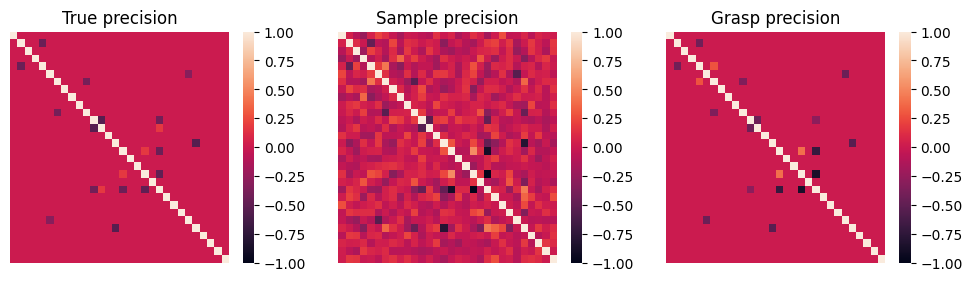

In [30]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3))

sns.heatmap(prec, vmin=-1, vmax=1, ax=axes[0])
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].set_title('True precision')

sns.heatmap(prec_sample, vmin=-1, vmax=1, ax=axes[1])
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].set_title('Sample precision')

sns.heatmap(prec_, vmin=-1, vmax=1, ax=axes[2])
axes[2].set_xticks([])
axes[2].set_yticks([])
axes[2].set_title('Grasp precision')

plt.show()